In [26]:
from collections import defaultdict, Counter
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize_scalar
import seaborn as sns
import spacy
from scipy.stats import ttest_ind
from tqdm.notebook import trange, tqdm
import os
import json
%matplotlib inline

### Load generated utterances with metadata

In [2]:
_df = pd.concat([
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/19dec/appliances.csv'),
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/19dec/food.csv'),
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/19dec/indoor.csv'),
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/19dec/outdoor.csv'),
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/19dec/vehicles.csv')
]
    , ignore_index=True
)

# _df = pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/19dec/all.csv')

In [3]:
print('target domain   :', _df['target domain'].unique())
print('listener domain :', _df['listener domain'].unique())
print('simulator domain:', _df['simulator domain'].unique())
# _df = _df.dropna()
print('Data points:', len(_df))

# Only asymmetric interactions
_df = _df[_df['listener domain'] != 'all']
_df = _df[_df['simulator domain'] != 'all']


target domain   : ['food' 'vehicles' 'outdoor' 'indoor' 'appliances']
listener domain : ['appliances' 'food' 'indoor' 'outdoor' 'vehicles']
simulator domain: ['appliances' 'food' 'indoor' 'outdoor' 'vehicles']
Data points: 23740


In [4]:
N_STEPS = 24
utt_types = [f"adapted utt s{step}" for step in range(N_STEPS)]

success_column = [] 
last_step_column = []

for j, row in _df.iterrows():
    last_step = N_STEPS - 1
    for i, utt_type in enumerate(utt_types):
        if type(row[utt_type]) is not str:
            last_step = i - 1
            break
    if row[f"adapted_acc_s{last_step}"] == 1:
        success_column.append("Successful")
    elif row[f"adapted_acc_s{last_step}"] == 0:
        success_column.append("Unsuccessful")
    else:
        raise ValueError()
    
    last_step_column.append(last_step)
    
_df["success"] = success_column
_df["last_step"] = last_step_column


In [5]:
# Split interactions with in-domain and out-of-domain listeners
id_df = _df[(_df['target domain'] == _df['listener domain'])]
ood_df = _df[(_df['target domain'] != _df['listener domain'])]

### AoA and concreteness ratings

In [6]:
aoa_filepath = "/Users/mario/code/pb_speaker_adaptation/src/analysis/AoA_51715_words.tsv"
conc_filepath = "/Users/mario/code/pb_speaker_adaptation/src/analysis/concreteness-ratings.tsv"

aoa_ratings = pd.read_csv(aoa_filepath, delimiter="\t")
conc_ratings = pd.read_csv(conc_filepath, delimiter="\t")


In [7]:
assert len(aoa_ratings.Word.unique()) == len(aoa_ratings)

word2aoa = dict()
for _, row in aoa_ratings.iterrows():
    spelling1 = row["Word"]
    spelling2 = row["Alternative.spelling"]
    
    # nan
    if type(row["AoA_Kup_lem"]) is float:
        continue

    word2aoa[spelling1] = float(row["AoA_Kup_lem"].replace(",", "."))
    if spelling2 not in word2aoa:
        word2aoa[spelling2] = float(row["AoA_Kup_lem"].replace(",", "."))


assert len(conc_ratings.Word.unique()) == len(conc_ratings)

word2conc = dict()
for _, row in conc_ratings.iterrows():
    word2conc[row["Word"]] = float(row["Conc.M"])

### Domain vocabularies

In [8]:
vocab_dir = "/Users/mario/code/pb_speaker_adaptation/src/analysis/domain_vocabs"

vocabs = dict()
for filepath in os.listdir(vocab_dir):
    domain = filepath.split(".")[0].split("_")[-1]

    with open(os.path.join(vocab_dir, filepath), "r") as f:
        vocab = json.load(f)
        vocabs[domain] = set(vocab)


specific_vocabs = defaultdict(set)

for domain in vocabs:
    other_vocabs = set().union(*[v for d, v in vocabs.items() if d != domain])
    
    for w in vocabs[domain]:
        if w not in other_vocabs:
            specific_vocabs[domain].add(w)

In [9]:
for v in specific_vocabs.values():
    print(len(v))

314
519
602
1138
882


In [10]:
spacy_processor = spacy.load("en_core_web_sm")

In [11]:
N_STEPS = 24

aoa_column = []
conc_column = []
img_domain_column = []
list_domain_column = []
img_domain_specific_column = []
list_domain_specific_column = []

utt_types = ["original utt"] + [f"adapted utt s{step}" for step in range(N_STEPS)]

for i, row in tqdm(_df.iterrows()):
#     print(i)
    
    aoa_column.append([])
    conc_column.append([])
    img_domain_column.append([])
    list_domain_column.append([])
    img_domain_specific_column.append([])
    list_domain_specific_column.append([])

    for utt_type in utt_types:
       
        utt = row[utt_type]
        # original utterances are stored in a 1-element list
        if utt_type == 'original utt':
            utt = eval(utt)[0]
        
        # nan -- no utterance at this adapation step
        if type(utt) is float:
            aoa_column[i].append(np.nan)
            conc_column[i].append(np.nan)
            img_domain_column[i].append(np.nan)
            list_domain_column[i].append(np.nan)
            img_domain_specific_column[i].append(np.nan)
            list_domain_specific_column[i].append(np.nan)
            continue

        aoa_utt = []
        conc_utt = []
        img_domain_utt = []
        list_domain_utt = []
        img_domain_specific_utt = []
        list_domain_specific_utt = []

        for w in spacy_processor(utt.strip()):
#             print(w.text)

            if w.text in word2aoa:
                aoa_utt.append(word2aoa[w.text])
            elif w.lemma_ in word2aoa:
                aoa_utt.append(word2aoa[w.lemma_])
            
            if w.text in word2conc:
                conc_utt.append(word2conc[w.text])
            elif w.lemma_ in word2conc:
                conc_utt.append(word2conc[w.lemma_])
            
            if w.text in vocabs[row["target domain"]]:
                img_domain_utt.append(1)
            elif w.lemma_ in vocabs[row["target domain"]]:
                img_domain_utt.append(1)
            else:
                img_domain_utt.append(0)
            
            if w.text in vocabs[row["listener domain"]]:
                list_domain_utt.append(1)
            elif w.lemma_ in vocabs[row["listener domain"]]:
                list_domain_utt.append(1)
            else:
                list_domain_utt.append(0)
                
            if w.text in specific_vocabs[row["target domain"]]:
                img_domain_specific_utt.append(1)
            elif w.lemma_ in specific_vocabs[row["target domain"]]:
                img_domain_specific_utt.append(1)
            else:
                img_domain_specific_utt.append(0)
            
            if w.text in specific_vocabs[row["listener domain"]]:
                list_domain_specific_utt.append(1)
            elif w.lemma_ in specific_vocabs[row["listener domain"]]:
                list_domain_specific_utt.append(1)
            else:
                list_domain_specific_utt.append(0)

        aoa_column[i].append(np.mean(aoa_utt))
        conc_column[i].append(np.mean(conc_utt))
        img_domain_column[i].append(np.mean(img_domain_utt))
        list_domain_column[i].append(np.mean(list_domain_utt))
        img_domain_specific_column[i].append(np.mean(img_domain_specific_utt))
        list_domain_specific_column[i].append(np.mean(list_domain_specific_utt))
        
        if len(aoa_column[i]) > 25:
            print(i)
            print(utt_type)
            print(aoa_utt)
            print(aoa_column[i])


0it [00:00, ?it/s]

/Users/mario/code/pb_speaker_adaptation/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mario/code/pb_speaker_adaptation/venv/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
N_STEPS = 24

aoa_column = []
conc_column = []
img_domain_column = []
list_domain_column = []
img_domain_specific_column = []
list_domain_specific_column = []

utt_types = ["original utt"] + [f"adapted utt s{step}" for step in range(N_STEPS)]

for i, row in tqdm(_df.iterrows()):
#     print(i)
    
    aoa_column.append([])
    conc_column.append([])
    img_domain_column.append([])
    list_domain_column.append([])
    img_domain_specific_column.append([])
    list_domain_specific_column.append([])

    for utt_type in utt_types:
       
        utt = row[utt_type]
        # original utterances are stored in a 1-element list
        if utt_type == 'original utt':
            utt = eval(utt)[0]
        
        # nan -- no utterance at this adapation step
        if type(utt) is float:
            aoa_column[i].append(np.nan)
            conc_column[i].append(np.nan)
            img_domain_column[i].append(np.nan)
            list_domain_column[i].append(np.nan)
            img_domain_specific_column[i].append(np.nan)
            list_domain_specific_column[i].append(np.nan)
            continue

        aoa_utt = []
        conc_utt = []
        img_domain_utt = []
        list_domain_utt = []
        img_domain_specific_utt = []
        list_domain_specific_utt = []

        for w in spacy_processor(utt.strip()):
#             print(w.text)

            if w.text in word2aoa:
                aoa_utt.append(word2aoa[w.text])
            elif w.lemma_ in word2aoa:
                aoa_utt.append(word2aoa[w.lemma_])
            
            if w.text in word2conc:
                conc_utt.append(word2conc[w.text])
            elif w.lemma_ in word2conc:
                conc_utt.append(word2conc[w.lemma_])
            
            if w.text in vocabs[row["target domain"]]:
                img_domain_utt.append(1)
            elif w.lemma_ in vocabs[row["target domain"]]:
                img_domain_utt.append(1)
            else:
                img_domain_utt.append(0)
            
            if w.text in vocabs[row["listener domain"]]:
                list_domain_utt.append(1)
            elif w.lemma_ in vocabs[row["listener domain"]]:
                list_domain_utt.append(1)
            else:
                list_domain_utt.append(0)
                
            if w.text in specific_vocabs[row["target domain"]]:
                img_domain_specific_utt.append(1)
            elif w.lemma_ in specific_vocabs[row["target domain"]]:
                img_domain_specific_utt.append(1)
            else:
                img_domain_specific_utt.append(0)
            
            if w.text in specific_vocabs[row["listener domain"]]:
                list_domain_specific_utt.append(1)
            elif w.lemma_ in specific_vocabs[row["listener domain"]]:
                list_domain_specific_utt.append(1)
            else:
                list_domain_specific_utt.append(0)

        aoa_column[i].append(np.mean(aoa_utt))
        conc_column[i].append(np.mean(conc_utt))
        img_domain_column[i].append(np.mean(img_domain_utt))
        list_domain_column[i].append(np.mean(list_domain_utt))
        img_domain_specific_column[i].append(np.mean(img_domain_specific_utt))
        list_domain_specific_column[i].append(np.mean(list_domain_specific_utt))
        
        if len(aoa_column[i]) > 25:
            print(i)
            print(utt_type)
            print(aoa_utt)
            print(aoa_column[i])


0it [00:00, ?it/s]

In [13]:
aoa_df = pd.DataFrame({
    'Adaptation step': list(range(25)) * len(aoa_column),
    'Mean AoA': np.array(aoa_column).flatten()
})

conc_df = pd.DataFrame({
    'Adaptation step': list(range(25)) * len(conc_column),
    'Mean Concreteness': np.array(conc_column).flatten()
})

img_domain_df = pd.DataFrame({
    'Adaptation step': list(range(25)) * len(img_domain_column),
    'Rate of lexical choice from image domain': np.array(img_domain_column).flatten()
})

list_domain_df = pd.DataFrame({
    'Adaptation step': list(range(25)) * len(list_domain_column),
    'Rate of lexical choice from listener domain': np.array(list_domain_column).flatten()
})

img_domain_specific_df = pd.DataFrame({
    'Adaptation step': list(range(25)) * len(img_domain_specific_column),
    'Rate of lexical choice from image domain': np.array(img_domain_specific_column).flatten()
})

list_domain_specific_df = pd.DataFrame({
    'Adaptation step': list(range(25)) * len(list_domain_specific_column),
    'Rate of lexical choice from listener domain': np.array(list_domain_specific_column).flatten()
})

<AxesSubplot:xlabel='Adaptation step', ylabel='Mean AoA'>

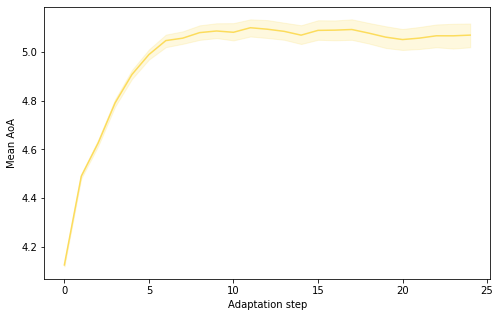

In [14]:
plt.rcParams["figure.figsize"] = (8,5)
sns.lineplot(data=aoa_df, x="Adaptation step", y="Mean AoA", color="#fcdc5c") #color="#ccc4a2")

<AxesSubplot:xlabel='Adaptation step', ylabel='Mean Concreteness'>

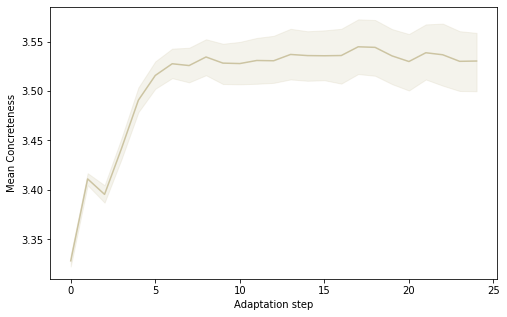

In [15]:
plt.rcParams["figure.figsize"] = (8,5)
sns.lineplot(data=conc_df, x="Adaptation step", y="Mean Concreteness", color="#ccc4a2")

<AxesSubplot:xlabel='Adaptation step', ylabel='Rate of lexical choice from image domain'>

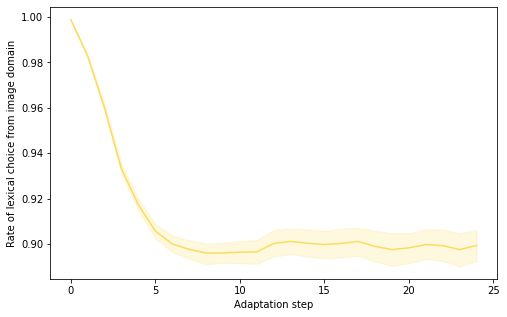

In [16]:
plt.rcParams["figure.figsize"] = (8,5)
sns.lineplot(data=img_domain_df, x="Adaptation step", y="Rate of lexical choice from image domain", color="#fcdc5c") #color="#ccc4a2")

<AxesSubplot:xlabel='Adaptation step', ylabel='Rate of lexical choice from listener domain'>

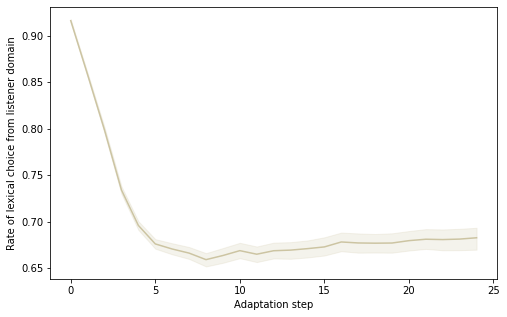

In [17]:
plt.rcParams["figure.figsize"] = (8,5)
sns.lineplot(data=list_domain_df, x="Adaptation step", y="Rate of lexical choice from listener domain", color="#ccc4a2")


<AxesSubplot:xlabel='Adaptation step', ylabel='Rate of lexical choice from image domain'>

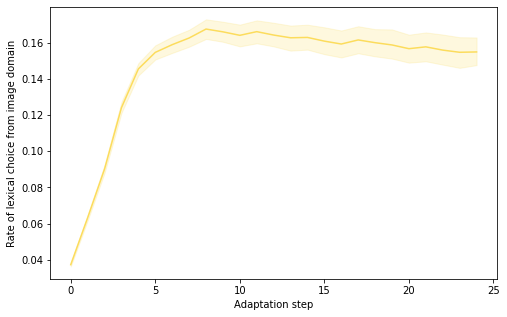

In [18]:
plt.rcParams["figure.figsize"] = (8,5)
sns.lineplot(data=img_domain_specific_df, x="Adaptation step", y="Rate of lexical choice from image domain", color="#fcdc5c") #color="#ccc4a2")


<AxesSubplot:xlabel='Adaptation step', ylabel='Rate of lexical choice from listener domain'>

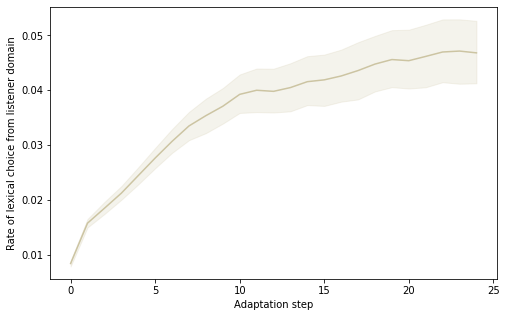

In [19]:
plt.rcParams["figure.figsize"] = (8,5)
sns.lineplot(data=list_domain_specific_df, x="Adaptation step", y="Rate of lexical choice from listener domain", color="#ccc4a2")



In [20]:
N_STEPS = 24
utt_types = [f"adapted utt s{step}" for step in range(N_STEPS)]

success_column = [] 
last_step_column = []

for j, row in _df.iterrows():

    last_step = 23
    for i, utt_type in enumerate(utt_types):
        if type(row[utt_type]) is not str:
#             print("laststep", i - 1)
            last_step = i - 1
            break

    if row[f"adapted_acc_s{last_step}"] == 1:
        success_column.append("Successful")
    elif row[f"adapted_acc_s{last_step}"] == 0:
        success_column.append("Unsuccessful")
    else:
        raise ValueError()
    
    last_step_column.append(last_step)

In [21]:
_df["success"] = success_column
_df["last_step"] = last_step 


In [24]:
last_aoa = []
last_conc = []
last_img_domain = []
last_list_domain = []
last_img_domain_specific = []
last_list_domain_specific = []

for i, row in _df.iterrows():
    last_aoa.append(aoa_column[i][row["last_step"]])
    last_conc.append(conc_column[i][row["last_step"]])
    last_img_domain.append(img_domain_column[i][row["last_step"]])
    last_list_domain.append(list_domain_column[i][row["last_step"]])
    last_img_domain_specific.append(img_domain_specific_column[i][row["last_step"]])
    last_list_domain_specific.append(list_domain_specific_column[i][row["last_step"]])
    
_df["AoA"] = last_aoa
_df["concreteness"] = last_conc
_df["img_domain_vocab"] = last_img_domain
_df["list_domain_vocab"] = last_list_domain
_df["img_domain_specific"] = last_img_domain_specific
_df["list_domain_specific"] = last_list_domain_specific


In [ ]:
plt.subplot(2,2)

In [28]:
group1 = _df[_df["success"] == "Successful"]
group2 = _df[_df["success"] == "Unsuccessful"]


ttest_ind(group1["concreteness"], group2['concreteness'], nan_policy='omit')  

Ttest_indResult(statistic=-0.25321132681726827, pvalue=0.8001130317287697)

In [32]:
specific_vocabs["indoor"]

{'1.same',
 '14',
 '20s',
 '4,5',
 '40s',
 '4people',
 '4th',
 '50',
 '50s',
 '60s',
 '70s',
 'abd',
 'abhout',
 'abot',
 'acrrot',
 'adjacent',
 'adn',
 'aerial',
 'afghan',
 'ahir',
 'aiming',
 'airal',
 'airy',
 'alot',
 'alptop',
 'america',
 "america's",
 'amouse',
 'anain',
 'anf',
 "animal's",
 'animals',
 'animls',
 'anothe',
 'anteana',
 'antena',
 'antenna',
 'antennae',
 'antennea',
 'aove',
 'ap',
 'aprone',
 'aquarium',
 'arch',
 'arches',
 'archways',
 'argyle',
 'arizona',
 'armchair',
 'armchairs',
 'armless',
 'aroubd',
 'asains',
 'atari',
 'att',
 'attenna',
 'audio',
 'automan',
 'ay',
 'backgro',
 'backgrsso',
 'baer',
 'bagels',
 'baige',
 'baldy',
 'bananaman',
 'bananans',
 'bananna',
 'bby',
 'beady',
 "bear's",
 'beared',
 'bears',
 'beaver',
 'belet',
 'beneath',
 'berars',
 'beras',
 'beroe',
 'bever',
 'beverages',
 'bib',
 'biege',
 'binky',
 'bistro',
 'blackberry',
 'blanked',
 'blanket',
 'blondish',
 'blone',
 'bluch',
 'blue-shirted',
 'blueand',
 'bl